In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math

from palettable.colorbrewer.diverging import RdBu_8

Define the expected reward function $\mu$

In [2]:
def mu(x,y):
    f = 0.5 * ((x - 0.8) ** 2 + (y - 0.7) ** 2) ** 0.5 + 0.3 * ((x - 0.1) ** 2 + (y - 0.1) ** 2) ** 0.5
    return 1-f

In [3]:
def mu(x, y):
    x1, x2 = 4*x - 2, 4*y - 2
    v1 = 1 + (x1 + x2 + 1)**2 * \
        (19 - 14*x1 + 3*x1**2 - 14*x2 + 6*x1*x2 + 3*x2**2)
    v2 = 30 + (2*x1 - 3*x2)**2 * \
        (18 - 32*x1 + 12*x1**2 + 48*x2 - 36*x1*x2 + 27*x2**2)
    reward = v1 * v2
    # reward = (np.log(v1 * v2) - 8.693 ) / 2.427
#     observation = np.random.normal(reward, 0.1)
    return reward
    

Maximum of $\mu$

In [4]:
delta = 1e-3
from itertools import product
linspace = np.linspace(0,1,1000)
arms = list(product(linspace, repeat=2))
fun_values = []
for arm in arms:
    fun_values.append(mu(arm[0], arm[1]))
fun_values = np.array(fun_values)
mu_m_delta = np.quantile(fun_values, 1-delta)
mu_m = np.max(fun_values)

Plot $\mu$

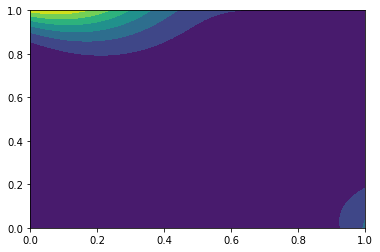

In [5]:
x = np.linspace(0, 1, 1000)
y = np.linspace(0, 1, 1000)
X, Y = np.meshgrid(x, y)
plt.contourf(X, Y, mu(X, Y))
plt.show()

In [6]:
def sample(p):
    x = np.random.uniform(cubes[p][0], cubes[p][0] + cubes[p][2])
    y = np.random.uniform(cubes[p][1], cubes[p][1] + cubes[p][2])
    return np.random.normal(mu(x, y), 0.1), mu(x, y)

In [7]:
def sample_final(time, p_h, p_t):
    global timer
    global regret
    global regret_delta
    pointer = p_h
    for t in range(time):
        r, mu_s = sample(pointer)
        cubes[pointer][3] = cubes[pointer][3] + r
        pointer = pointer + 1
        if pointer > p_t:
            pointer = p_h
        regret = regret + max(mu_m - mu_s, 0)
        regret_delta += max(mu_m_delta - mu_s, 0)
        regretlist.append(regret)
        regret_delta_lst.append(regret_delta)
        timer = timer + 1
    return(regret)

In [8]:
def sample_fullbatch(num, p_h, p_t):
    global timer
    global regret
    global regret_delta
    for t in range(num):
        for cube_now in range(p_h, p_t + 1):
            r, mu_s = sample(cube_now)
            cubes[cube_now][3] = cubes[cube_now][3] + r
            regret = regret + max(mu_m - mu_s, 0)
            regret_delta += max(mu_m_delta - mu_s, 0)
            regretlist.append(regret)
            regret_delta_lst.append(regret_delta)
            timer = timer + 1
    return(regret)

In [9]:
def eli_par(r, mu_max, p_h, p_t, num_p):
    p_new = p_t
    for p in range(p_h, p_t + 1):
        if mu_max - cubes[p][3] > 0.25 * r:  #mark2: 0.25
            cubes_eli.append([[cubes[p][0], cubes[p][0], cubes[p][0] + cubes[p][2], cubes[p][0] + cubes[p][2]], [cubes[p][1], cubes[p][1] + cubes[p][2], cubes[p][1] + cubes[p][2], cubes[p][1]]])
            continue
        for i in range(num_p):
            for j in range(num_p):
                cubes.append([cubes[p][0] + i * cubes[p][2] / num_p, cubes[p][1] + j * cubes[p][2] / num_p, cubes[p][2] / num_p, 0])
        p_new = p_new + num_p ** 2
        for i in range(num_p - 1):
            partition.append([cubes[p][0] + cubes[p][2] / num_p * (i + 1), cubes[p][1], cubes[p][0] + cubes[p][2] / num_p * (i + 1), cubes[p][1] + cubes[p][2]])
        for i in range(num_p - 1):
            partition.append([cubes[p][0], cubes[p][1] + cubes[p][2] / num_p * (i + 1), cubes[p][0] + cubes[p][2], cubes[p][1] + cubes[p][2] / num_p * (i + 1)])
    partition_grid.append(len(partition)-1)
    cubes_eli_grid.append(len(cubes_eli)-1)
    return p_new

In [10]:
regrets_all = []
regrets_delta_all = []

for i in range(10):
    print(i)
    T=60000
    edge_length = []
    num = []  # number of samples in each batch
    partition = []   # edge of the cubes
    partition_grid = []
    cubes_eli = []   # cubes that have been eliminated
    cubes_eli_grid = []
    regretlist = []
    regretlist.append(0)

    regret_delta_lst = []
    regret_delta_lst.append(0)

    grid = []
    timer = 0
    eli_cubes_num = [] #number of cubes totally eliminated each batch
    cubes_num = []

    # ACE Sequence

    ACE_c = []
    ACE_d = []
    ACE_c.append(1 / 6 * math.log2(T / math.log2(T)))
    c_cumu = ACE_c[-1]
    eta = 3 / 4
    B_star = math.ceil(math.log2(math.log2(T)) / math.log2(4 / 3))
    for i in range(B_star):
        ACE_d.append(math.floor(c_cumu))
        ACE_d.append(math.ceil(c_cumu))
        ACE_c.append(ACE_c[-1] * eta)
        c_cumu = c_cumu + ACE_c[-1]
    ACE_d = sorted(list(set(ACE_d)))

    for i in ACE_d:
        edge_length.append(pow(2, -i))

    for r in edge_length:
        num.append(math.ceil(0.1 * math.log(T) / (r) ** 2)) ###mark1 0.75

    cubes = []

    # x_location  y_location  edge_length  total_reward

    for i in range(round(1 / edge_length[0])):
        for j in range(round(1 / edge_length[0])):
            cubes.append([i * edge_length[0], j * edge_length[0], edge_length[0], 0])

    for i in range(round(1 / edge_length[0]) - 1):
        partition.append([0, edge_length[0] * (i + 1), 1, edge_length[0] * (i + 1)])
        partition.append([edge_length[0] * (i + 1), 0, edge_length[0] * (i + 1), 1])

    partition_grid.append(-1)
    partition_grid.append(len(partition)-1)

    cubes_eli_grid.append(-1)
    cubes_eli_grid.append(len(cubes_eli)-1)
    grid.append(0)

    pointer_h = 0
    pointer_t = round(1 / edge_length[0]) ** 2 - 1

    B_total = len(edge_length)



    T_accu = 0   # number of past rounds
    regret = 0
    regret_delta = 0

    for B in range(T):   # number of batches B is less than time horizon T
        if B == B_total:
            r = sample_final(T - T_accu, pointer_h, pointer_t)
            grid.append(T)
            break
        num_cube = pointer_t - pointer_h + 1
        num_round = num_cube * num[B]
        if (T_accu + num_round >= T) or (B == B_total):
            r = sample_final(T - T_accu, pointer_h, pointer_t)
            grid.append(T)
            break
        if T_accu + num_round < T:
            T_accu = T_accu + num_round
            r = sample_fullbatch(num[B], pointer_h, pointer_t)
            grid.append(T_accu)
            # compute the average reward for each cube and the maximal
            hat_mu_max = 0
            for p in range(pointer_h, pointer_t + 1):
                cubes[p][3] = cubes[p][3] / num[B]
                if cubes[p][3] > hat_mu_max:
                    hat_mu_max = cubes[p][3]
            if B == B_total -1:
                num_p = 2
            else:
                num_p = round(edge_length[B] / edge_length[B + 1])
            cubes_num.append(len(cubes))
            p_t = eli_par(edge_length[B], hat_mu_max, pointer_h, pointer_t, num_p)

            eli_cubes_num.append(len(cubes_eli))

            pointer_h = pointer_t + 1
            pointer_t = p_t
            
        
    print('cubes_num', cubes_num)
    print('eli_cubes_num', eli_cubes_num)

            
                
    regrets_all.append(regretlist)
    regrets_delta_all.append(regret_delta_lst)

0
cubes_num [4, 8, 12, 16, 20, 24]
eli_cubes_num [3, 6, 9, 12, 15, 18]
1
cubes_num [4, 8, 12, 16, 20, 24]
eli_cubes_num [3, 6, 9, 12, 15, 18]
2
cubes_num [4, 8, 12, 16, 20, 24]
eli_cubes_num [3, 6, 9, 12, 15, 18]
3
cubes_num [4, 8, 12, 16, 20, 24]
eli_cubes_num [3, 6, 9, 12, 15, 18]
4
cubes_num [4, 8, 12, 16, 20, 24]
eli_cubes_num [3, 6, 9, 12, 15, 18]
5
cubes_num [4, 8, 12, 16, 20, 24]
eli_cubes_num [3, 6, 9, 12, 15, 18]
6
cubes_num [4, 8, 12, 16, 20, 24]
eli_cubes_num [3, 6, 9, 12, 15, 18]
7
cubes_num [4, 8, 12, 16, 20, 24]
eli_cubes_num [3, 6, 9, 12, 15, 18]
8
cubes_num [4, 8, 12, 16, 20, 24]
eli_cubes_num [3, 6, 9, 12, 15, 18]
9
cubes_num [4, 8, 12, 16, 20, 24]
eli_cubes_num [3, 6, 9, 12, 15, 18]


In [11]:
print('cubes_num', cubes_num)
print('eli_cubes_num', eli_cubes_num)

cubes_num [4, 8, 12, 16, 20, 24]
eli_cubes_num [3, 6, 9, 12, 15, 18]


In [12]:
# cum_regret = np.loadtxt('cum_regret_zooming.csv')
# code of zooming algorithm is modified from 1-dimension version presented at https://github.com/runninglsy/Lipschitz-bandits-experiment

In [14]:
import numpy as np
regret_m = np.mean(regrets_all, axis=0)
regret_std = np.std(regrets_all, axis=0)
regret_m_delta = np.mean(regrets_delta_all, axis=0)
regret_std_delta = np.std(regrets_delta_all, axis=0)

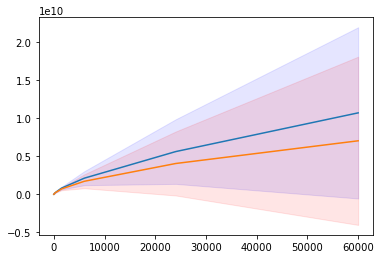

In [15]:
import matplotlib.pyplot as plt
plt.plot(regret_m)
plt.plot(regret_m_delta)
plt.fill_between(np.array(range(len(regret_m))), 
                 regret_m - regret_std, regret_m + regret_std, alpha=0.1, color='b')
plt.fill_between(np.array(range(len(regret_m_delta))), 
                                regret_m_delta - regret_std_delta, regret_m_delta + regret_std_delta, alpha=0.1, color='r')
plt.show()

In [16]:
import numpy as np
np.savetxt('ABLiN_delta.csv', regret_m_delta)
np.savetxt('ABLiN.csv', regret_m)
np.savetxt('ABLiN_std.csv', regret_std)
np.savetxt('ABLiN_std_delta.csv', regret_std_delta)

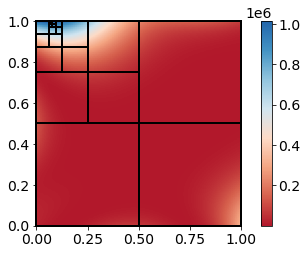

In [15]:
plt.rcParams['font.size']=14
x = np.linspace(0, 1, 100)
y = np.linspace(1, 0, 100)
X, Y = np.meshgrid(x, y)
Z = mu(X,Y)
plt.imshow(Z, cmap=RdBu_8.mpl_colormap, extent = [0,1,0,1],)
for line in partition:
    if line[0] == line[2]:
        plt.axvline(line[0], line[1], line[3], color = 'k', linewidth = 2)
    if line[1] == line[3]:
        plt.axhline(line[1], line[0], line[2], color = 'k', linewidth = 2)
plt.colorbar()
plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)

plt.xlabel(' ')

plt.tight_layout()
# plt.savefig('partition.png')

In [16]:
grid

[0, 20, 92, 376, 1504, 6012, 24040, 60000]

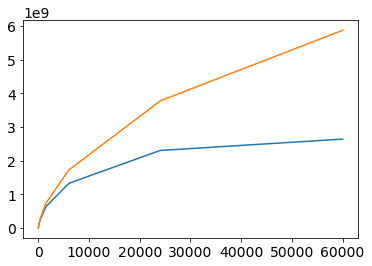

In [22]:
# plt.rcParams['font.size']=14
# colorbar = ['red', '#FF9900', 'blue', 'green']
# shadow = ['#FCE4BF', '#F5F5B4', '#CDF8F8', '#B9F8B9']
# plt.ylim([0, 3500])
# plt.xlim([0, 80000])
# for i in range(4):
#     plt.fill([grid[i], grid[i], grid[i+1], grid[i+1]], [0, 3500, 3500, 0], color = shadow[i])
#     plt.plot(np.linspace(grid[i], grid[i+1], grid[i+1] + 1 - grid[i]), regretlist[grid[i]: grid[i+1] + 1], color = colorbar[i], linewidth = 1)

# l1 = plt.plot(np.linspace(0, 80000, 80001), cum_regret, color = 'red', linewidth = 2, ls = '--', label = 'Zooming')

l1 = plt.plot(np.linspace(0, T, T+1), regret_delta_lst)
l2 = plt.plot(np.linspace(0, T, T+1), regretlist)
np.savetxt('ablin_regret.csv', regretlist)
np.savetxt('ablin_regret_delta.csv', regret_delta_lst)
    
# gap = 2000
# n = int(T / gap)
# for i in range(n):
#     t = (i + 1) * gap
#     for j in range(4):
#         if (grid[j] < t) and (grid[j + 1] >= t):
#             plt.plot(t, regretlist[t], marker = 'v', markeredgewidth = 0.5, markeredgecolor = 'black', markerfacecolor = colorbar[j])
            
# plt.xlabel('t')
# plt.ylabel('Regret')


# plt.legend(loc = 'lower right')

# plt.gca().spines['top'].set_linewidth(2)
# plt.gca().spines['right'].set_linewidth(2)
# plt.gca().spines['bottom'].set_linewidth(2)
# plt.gca().spines['left'].set_linewidth(2)

# plt.tight_layout()
# plt.savefig('regret.png')

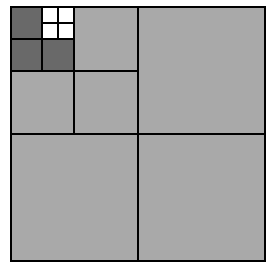

In [33]:
plt.rcParams['font.size']=14
for k in range(1, 5):
    for line in partition[0: partition_grid[k] + 1]:
        if line[0] == line[2]:
            plt.axvline(line[0], line[1], line[3], color = 'k', linewidth = 2)
        if line[1] == line[3]:
            plt.axhline(line[1], line[0], line[2], color = 'k', linewidth = 2)
    plt.axis('scaled')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    for cube_e in cubes_eli[0: cubes_eli_grid[k - 1] + 1]:
        plt.fill(cube_e[0], cube_e[1], color = '#A9A9A9')
    for cube_e in cubes_eli[cubes_eli_grid[k - 1] + 1: cubes_eli_grid[k] + 1]:
        plt.fill(cube_e[0], cube_e[1], color = '#696969')
    plt.xticks([])
    plt.yticks([])
    plt.gca().spines['top'].set_linewidth(2)
    plt.gca().spines['right'].set_linewidth(2)
    plt.gca().spines['bottom'].set_linewidth(2)
    plt.gca().spines['left'].set_linewidth(2)
    
    plt.tight_layout()
#     plt.savefig('partition_step_'+str(k)+'.png')